     PURPOSE
The primary objective of this notebook is to perform comprehensive customer segmentation using transactional and demographic data. By analyzing historical behavior, we aim to identify distinct customer groups along with their definitions and rules.

    Dataset overview

Source: https://www.kaggle.com/datasets/shivamb/bank-customer-segmentation/data

Features: Includes raw data such as CustomerID, CustLocation, CustGender, CustAccountBalance, TransactionDate, and CustomerDOB. These raw features were engineered into derived features such as Age, RFM metrics,etc.

IMPORT THE NECESSARY LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Bank Clusters/bank_transactions.csv'

df = pd.read_csv(file_path)

df.head(5)


Mounted at /content/drive


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [3]:
df.shape

(1048567, 9)

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustAccountBalance,1046198.0,115403.540056,846485.380601,0.0,4721.76,16792.18,57657.36,1.150355e+08
TransactionTime,1048567.0,157087.529393,51261.854022,0.0,124030.00,164226.00,200010.00,2.359590e+05
TransactionAmount (INR),1048567.0,1574.335003,6574.742978,0.0,161.00,459.03,1200.00,1.560035e+06


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [6]:
print(df['CustomerID'].nunique())


884265


In [7]:
#Check and drop null values
print(df.isna().sum().sum())
df.dropna(inplace=True)



7017


In [8]:
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)


Number of duplicate rows: 0


In [9]:
print(df['CustomerID'].value_counts().head())

CustomerID
C4513786    6
C6735477    6
C6624352    6
C1736254    6
C1113684    6
Name: count, dtype: int64


Data Quality and Validity checks

In [10]:
df.head(4)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0


In [11]:



df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], errors='coerce', dayfirst=True)

today = pd.Timestamp.today()
df['CustomerDOB'] = df['CustomerDOB'].apply(lambda x: x - pd.DateOffset(years=100) if x > today else x)

df['Age'] = (today - df['CustomerDOB']).dt.days // 365

df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], errors='coerce', dayfirst=True)

# Convert TransactionTime (HHMMSS) to a readable time format
df['TransactionTime'] = pd.to_datetime(df['TransactionTime'].astype(str).str.zfill(6), format='%H%M%S').dt.time

# Filter for valid data
df = df[(df['Age'] >= 18) & (df['Age'] <= 100)]
df = df.dropna(subset=['CustomerDOB', 'TransactionDate'])

df[['CustomerDOB', 'Age', 'TransactionDate', 'TransactionTime']].head()


/tmp/ipython-input-4012197179.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], errors='coerce', dayfirst=True)
/tmp/ipython-input-4012197179.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], errors='coerce', dayfirst=True)


,CustomerDOB,Age,TransactionDate,TransactionTime
0,1994-01-10,32,2016-08-02,14:32:07
1,1957-04-04,68,2016-08-02,14:18:58
2,1996-11-26,29,2016-08-02,14:27:12
3,1973-09-14,52,2016-08-02,14:27:14
4,1988-03-24,37,2016-08-02,18:11:56


Transaction amount validity

In [12]:
# negatives
print((df['TransactionAmount (INR)'] < 0).sum())

# zeros
print((df['TransactionAmount (INR)'] == 0).sum())

# distribution
df['TransactionAmount (INR)'].describe()


0
708


,TransactionAmount (INR)
count,9.851350e+05
mean,1.452108e+03
std,6.139723e+03
min,0.000000e+00
25%,1.510000e+02
50%,4.310000e+02
75%,1.125000e+03
max,1.560035e+06


Account balance validity

In [13]:
print((df['CustAccountBalance'] < 0).sum())
df['CustAccountBalance'].describe()


0


,CustAccountBalance
count,9.851350e+05
mean,1.060318e+05
std,8.179372e+05
min,0.000000e+00
25%,4.581290e+03
50%,1.600008e+04
75%,5.374266e+04
max,1.150355e+08


Time validity


flag transactions whose transactionamount is zero

In [14]:
df['is_zero_txn'] = (df['TransactionAmount (INR)'] == 0).astype(int)


In [15]:
df.head(10)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Age,is_zero_txn
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2016-08-02,14:32:07,25.00,32,0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-08-02,14:18:58,27999.00,68,0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-08-02,14:27:12,459.00,29,0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-08-02,14:27:14,2060.00,52,0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-08-02,18:11:56,1762.50,37,0
5,T6,C1536588,1972-10-08,F,ITANAGAR,53609.20,2016-08-02,17:39:40,676.00,53,0
6,T7,C7126560,1992-01-26,F,MUMBAI,973.46,2016-08-02,17:38:06,566.00,34,0
7,T8,C1220223,1982-01-27,M,MUMBAI,95075.54,2016-08-02,17:05:37,148.00,44,0
8,T9,C8536061,1988-04-19,F,GURGAON,14906.96,2016-08-02,19:28:25,833.00,37,0
9,T10,C6638934,1984-06-22,M,MUMBAI,4279.22,2016-08-02,19:24:46,289.11,41,0


Aggregation

Transaction-level records are aggregated into a single profile per customer to capture financial behavior, engagement intensity, and temporal activity. Key metrics such as total and average spend, transaction frequency, recency, and spending variability are derived to represent customer behavior over time.

In [16]:
import numpy as np

# 1. Create a customer-level aggregation
cust_df = df.groupby('CustomerID').agg(
    # Financial
    CustAccountBalance=('CustAccountBalance', 'mean'),
    TotalSpend=('TransactionAmount (INR)', 'sum'),
    AvgSpend=('TransactionAmount (INR)', 'mean'),
    MaxSpend=('TransactionAmount (INR)', 'max'),
    MinSpend=('TransactionAmount (INR)', 'min'),
    StdSpend=('TransactionAmount (INR)', 'std'),

    # Behavioral
    TransactionCount=('TransactionID', 'count'),
    ZeroTxnCount=('is_zero_txn', 'sum'),

    # Temporal/Engagement
    LastTxnDate=('TransactionDate', 'max'),
    FirstTxnDate=('TransactionDate', 'min')
).reset_index()

# 2. Fix Variance and Derived Metrics
cust_df['StdSpend'] = cust_df['StdSpend'].fillna(0)
cust_df['ZeroTxnFraction'] = cust_df['ZeroTxnCount'] / cust_df['TransactionCount']

# 3. Calculate Recency and Frequency
# Use a fixed reference point
ref_date = cust_df['LastTxnDate'].max()
cust_df['RecencyDays'] = (ref_date - cust_df['LastTxnDate']).dt.days

# Avoid division by zero in frequency
duration_months = ((cust_df['LastTxnDate'] - cust_df['FirstTxnDate']).dt.days + 1) / 30
cust_df['FrequencyPerMonth'] = cust_df['TransactionCount'] / duration_months

# 4. Merge Demographics
demographics = df.groupby('CustomerID').agg({
    'Age': 'first',
    'CustGender': 'first',
    'CustLocation': 'first'
}).reset_index()

cust_df = cust_df.merge(demographics, on='CustomerID', how='left')

# 5. Final Cleanup for EDA
cust_df.replace([np.inf, -np.inf], 0, inplace=True)
cust_df.fillna(0, inplace=True)

print(f"Dataset transformed to {cust_df.shape[0]} unique customer profiles.")
cust_df.head()


Dataset transformed to 838939 unique customer profiles.


,CustomerID,CustAccountBalance,TotalSpend,AvgSpend,MaxSpend,MinSpend,StdSpend,TransactionCount,ZeroTxnCount,LastTxnDate,FirstTxnDate,ZeroTxnFraction,RecencyDays,FrequencyPerMonth,Age,CustGender,CustLocation
0,C1010011,76340.635,5106.0,2553.0,4750.0,356.0,3107.027197,2,0,2016-09-26,2016-08-09,0.0,25,1.224490,33,F,NOIDA
1,C1010012,24204.490,1499.0,1499.0,1499.0,1499.0,0.000000,1,0,2016-08-14,2016-08-14,0.0,68,30.000000,31,M,MUMBAI
2,C1010014,100112.950,1455.0,727.5,1205.0,250.0,675.286976,2,0,2016-08-07,2016-08-01,0.0,75,8.571429,33,F,MUMBAI
3,C1010018,496.180,30.0,30.0,30.0,30.0,0.000000,1,0,2016-09-15,2016-09-15,0.0,36,30.000000,35,F,CHAMPARAN
4,C1010024,87058.650,5000.0,5000.0,5000.0,5000.0,0.000000,1,0,2016-08-18,2016-08-18,0.0,64,30.000000,60,M,KOLKATA


In [17]:
df.head(5)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Age,is_zero_txn
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2016-08-02,14:32:07,25.0,32,0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-08-02,14:18:58,27999.0,68,0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-08-02,14:27:12,459.0,29,0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-08-02,14:27:14,2060.0,52,0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-08-02,18:11:56,1762.5,37,0


In this step we add information about when customers transact, how much they spend relative to their balance, and whether they live in major cities to better describe customer behavior for segmentation.


In [18]:
import pandas as pd

# 1. Behavioral: Extract Hour and identify Night Transactions (12AM - 4AM) in the main df

df['Hour'] = df['TransactionTime'].astype(str).str.split(':').str[0].astype(int)
night_counts = df[df['Hour'].between(0, 4)].groupby('CustomerID').size().rename('NightTxnCount')

# 2. Merge this behavior back into your aggregated cust_df
cust_df = cust_df.merge(night_counts, on='CustomerID', how='left').fillna({'NightTxnCount': 0})
cust_df['NightTxnFraction'] = cust_df['NightTxnCount'] / cust_df['TransactionCount']

# 3. Financial Health: Calculate the Balance-to-Spend ratio
# (+1 prevents division by zero)
cust_df['BalanceToSpendRatio'] = cust_df['CustAccountBalance'] / (cust_df['AvgSpend'] + 1)

# 4. Lifestyle: Flag Metro locations
metro_cities = ['MUMBAI', 'DELHI', 'BANGALORE', 'CHENNAI', 'KOLKATA', 'HYDERABAD', 'PUNE']
cust_df['IsMetro'] = cust_df['CustLocation'].str.upper().isin(metro_cities).astype(int)

# View the new profiling features
cust_df[['CustomerID', 'NightTxnFraction', 'BalanceToSpendRatio', 'IsMetro']].head()


,CustomerID,NightTxnFraction,BalanceToSpendRatio,IsMetro
0,C1010011,0.5,29.890617,0
1,C1010012,0.0,16.136327,1
2,C1010014,0.0,137.423404,1
3,C1010018,0.0,16.005806,0
4,C1010024,0.0,17.408248,1


We apply a logic correction to the FrequencyPerMonth metric by capping users with only one transaction at a value of 1.0. This prevents one-time users from appearing as high-frequency power users due to their short activity window

In [19]:
cust_df.loc[cust_df['TransactionCount'] == 1, 'FrequencyPerMonth'] = 1.0


In [20]:
pd.set_option('display.max_columns', None)
cust_df.head(10)


,CustomerID,CustAccountBalance,TotalSpend,AvgSpend,MaxSpend,MinSpend,StdSpend,TransactionCount,ZeroTxnCount,LastTxnDate,FirstTxnDate,ZeroTxnFraction,RecencyDays,FrequencyPerMonth,Age,CustGender,CustLocation,NightTxnCount,NightTxnFraction,BalanceToSpendRatio,IsMetro
0,C1010011,76340.635,5106.0,2553.0,4750.0,356.0,3107.027197,2,0,2016-09-26,2016-08-09,0.0,25,1.224490,33,F,NOIDA,1.0,0.5,29.890617,0
1,C1010012,24204.490,1499.0,1499.0,1499.0,1499.0,0.000000,1,0,2016-08-14,2016-08-14,0.0,68,1.000000,31,M,MUMBAI,0.0,0.0,16.136327,1
2,C1010014,100112.950,1455.0,727.5,1205.0,250.0,675.286976,2,0,2016-08-07,2016-08-01,0.0,75,8.571429,33,F,MUMBAI,0.0,0.0,137.423404,1
3,C1010018,496.180,30.0,30.0,30.0,30.0,0.000000,1,0,2016-09-15,2016-09-15,0.0,36,1.000000,35,F,CHAMPARAN,0.0,0.0,16.005806,0
4,C1010024,87058.650,5000.0,5000.0,5000.0,5000.0,0.000000,1,0,2016-08-18,2016-08-18,0.0,64,1.000000,60,M,KOLKATA,0.0,0.0,17.408248,1
5,C1010028,296828.370,557.0,557.0,557.0,557.0,0.000000,1,0,2016-08-29,2016-08-29,0.0,53,1.000000,37,F,DELHI,0.0,0.0,531.950484,1
6,C1010031,5200.155,1864.0,932.0,1460.0,404.0,746.704761,2,0,2016-08-04,2016-08-03,0.0,78,30.000000,41,M,VAPI,0.0,0.0,5.573585,0
7,C1010035,192648.755,750.0,375.0,700.0,50.0,459.619408,2,0,2016-08-27,2016-08-01,0.0,55,2.222222,33,M,MUMBAI,0.0,0.0,512.363710,1
8,C1010036,355430.170,208.0,208.0,208.0,208.0,0.000000,1,0,2016-08-26,2016-08-26,0.0,56,1.000000,29,M,GURGAON,0.0,0.0,1700.622823,0
9,C1010037,95859.170,19680.0,19680.0,19680.0,19680.0,0.000000,1,0,2016-08-09,2016-08-09,0.0,73,1.000000,44,M,BANGALORE,0.0,0.0,4.870645,1


EDA

Age distribution

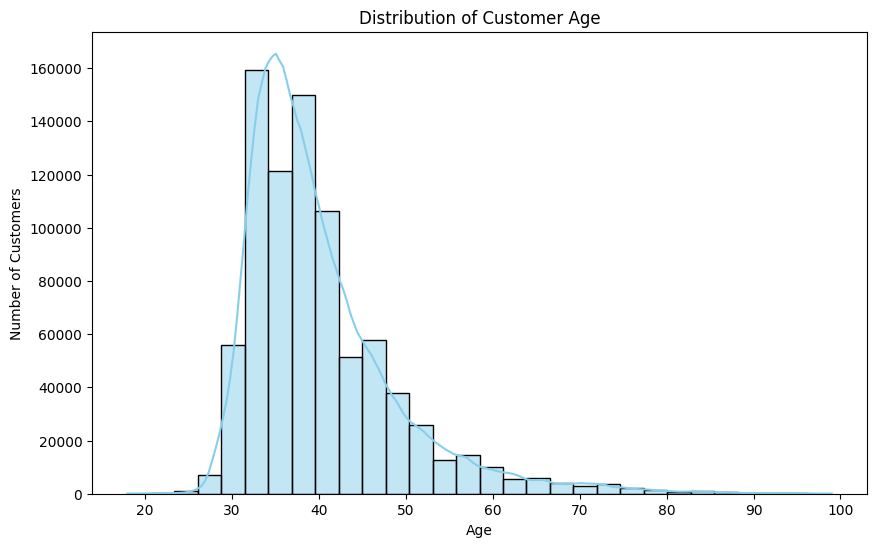

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(cust_df['Age'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Customer Age')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.show()


Total spend distribution


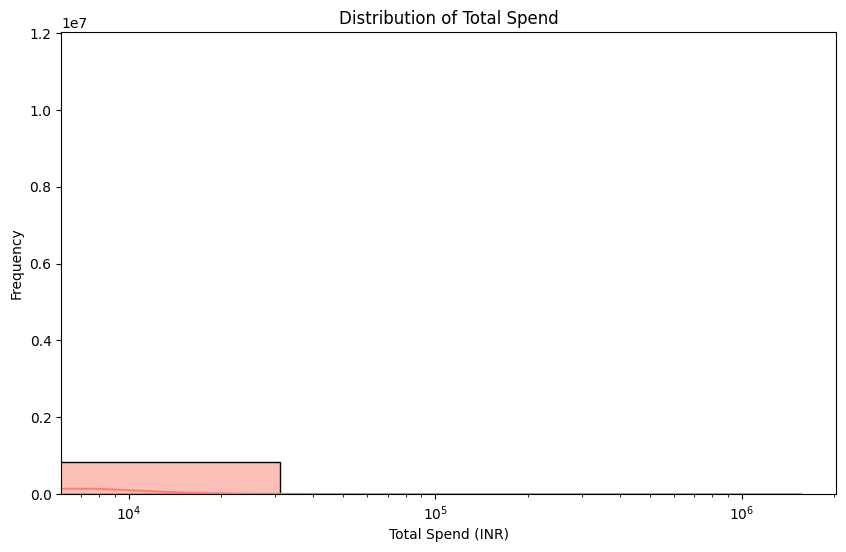

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(cust_df['TotalSpend'], bins=50, kde=True, color='salmon')
plt.title('Distribution of Total Spend')
plt.xlabel('Total Spend (INR)')
plt.ylabel('Frequency')
# Using a log scale if the data is very skewed
plt.xscale('log')
plt.show()


This step Checks how customer features relate to each other to identify strong dependencies and reduce redundancy before clustering.

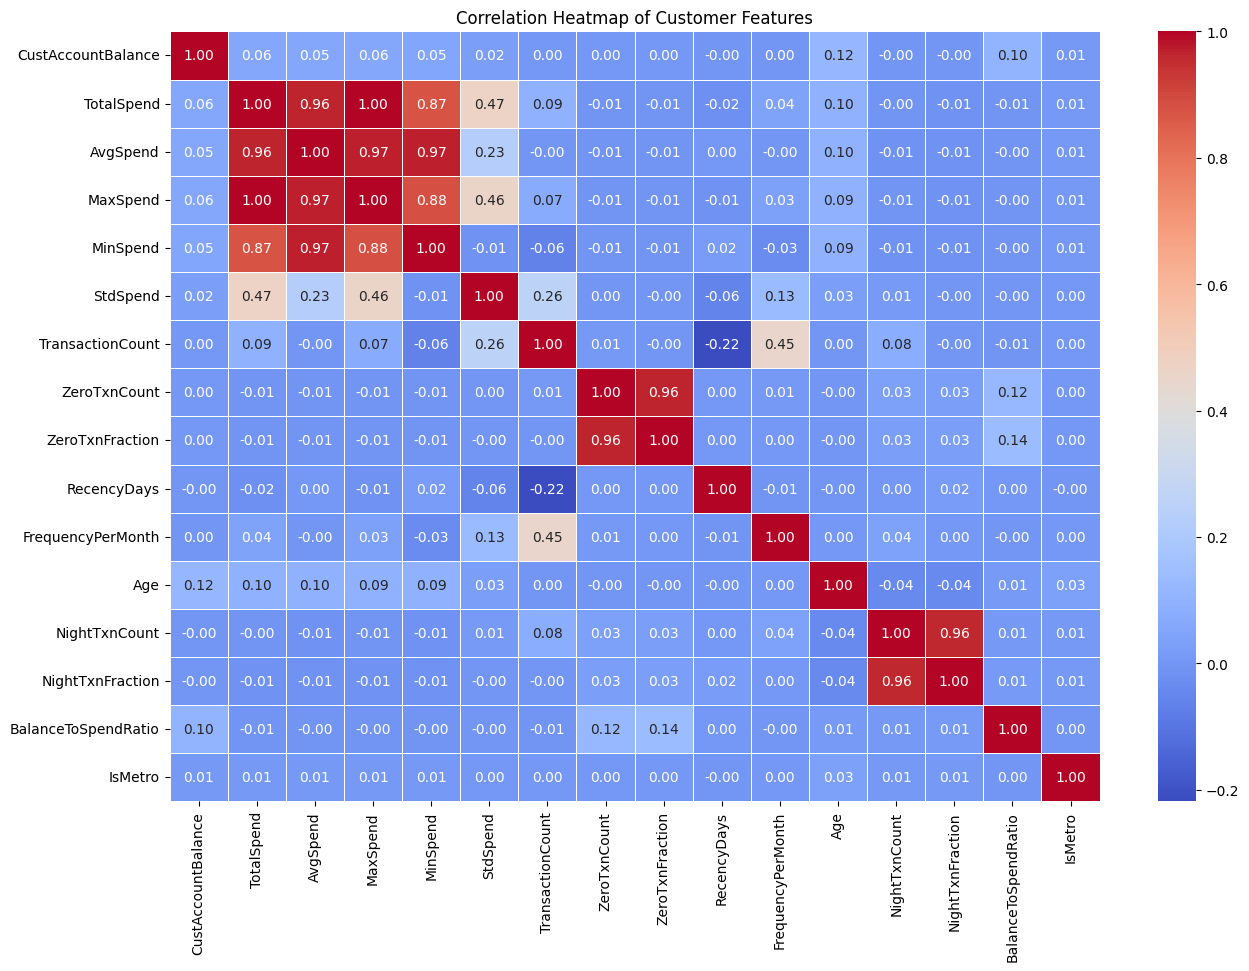

In [23]:
# Select only numeric columns for correlation
numeric_cols = cust_df.select_dtypes(include=[np.number]).columns
corr_matrix = cust_df[numeric_cols].corr()

# Visualize with a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Customer Features')
plt.show()


In [24]:
corr_matrix

,CustAccountBalance,TotalSpend,AvgSpend,MaxSpend,MinSpend,StdSpend,TransactionCount,ZeroTxnCount,ZeroTxnFraction,RecencyDays,FrequencyPerMonth,Age,NightTxnCount,NightTxnFraction,BalanceToSpendRatio,IsMetro
CustAccountBalance,1.000000,0.055828,0.054736,0.055680,0.049955,0.024804,0.000715,0.002351,0.002324,-0.003895,0.000248,0.115677,-0.003275,-0.003638,0.104785,0.006135
TotalSpend,0.055828,1.000000,0.963375,0.998386,0.874088,0.467840,0.093911,-0.005553,-0.006215,-0.018687,0.042403,0.095377,-0.004574,-0.011115,-0.005109,0.005988
AvgSpend,0.054736,0.963375,1.000000,0.968180,0.970247,0.228908,-0.000542,-0.006067,-0.006263,0.001914,-0.000128,0.096809,-0.010858,-0.010950,-0.004820,0.006099
MaxSpend,0.055680,0.998386,0.968180,1.000000,0.881706,0.458021,0.067592,-0.005393,-0.006014,-0.013160,0.031356,0.094379,-0.006016,-0.010807,-0.004961,0.005737
MinSpend,0.049955,0.874088,0.970247,0.881706,1.000000,-0.012859,-0.064833,-0.006350,-0.006125,0.016672,-0.033803,0.092983,-0.014798,-0.010427,-0.004371,0.005985
StdSpend,0.024804,0.467840,0.228908,0.458021,-0.012859,1.000000,0.255031,0.000442,-0.001229,-0.058222,0.132890,0.025577,0.014398,-0.003278,-0.002297,0.001035
TransactionCount,0.000715,0.093911,-0.000542,0.067592,-0.064833,0.255031,1.000000,0.009022,-0.000744,-0.218249,0.449429,0.000571,0.080329,-0.000408,-0.005992,0.002667
ZeroTxnCount,0.002351,-0.005553,-0.006067,-0.005393,-0.006350,0.000442,0.009022,1.000000,0.964622,0.001409,0.006360,-0.002129,0.029302,0.027716,0.122921,0.001546
ZeroTxnFraction,0.002324,-0.006215,-0.006263,-0.006014,-0.006125,-0.001229,-0.000744,0.964622,1.000000,0.003533,0.000795,-0.002078,0.027377,0.028677,0.137539,0.001596
RecencyDays,-0.003895,-0.018687,0.001914,-0.013160,0.016672,-0.058222,-0.218249,0.001409,0.003533,1.000000,-0.007794,-0.001710,0.000815,0.019319,0.000819,-0.000904


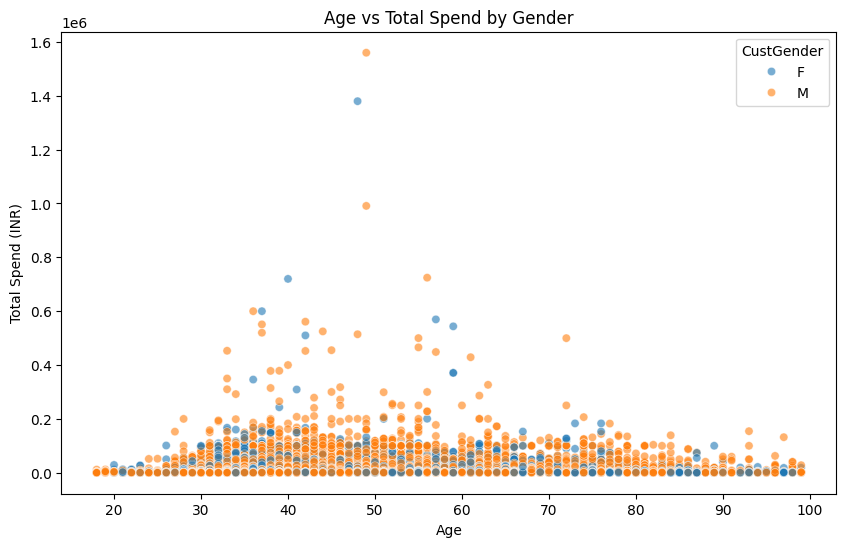

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cust_df, x='Age', y='TotalSpend', hue='CustGender', alpha=0.6)
plt.title('Age vs Total Spend by Gender')
plt.xlabel('Age')
plt.ylabel('Total Spend (INR)')
plt.show()


/tmp/ipython-input-470630826.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cust_df, x='CustGender', palette='pastel')


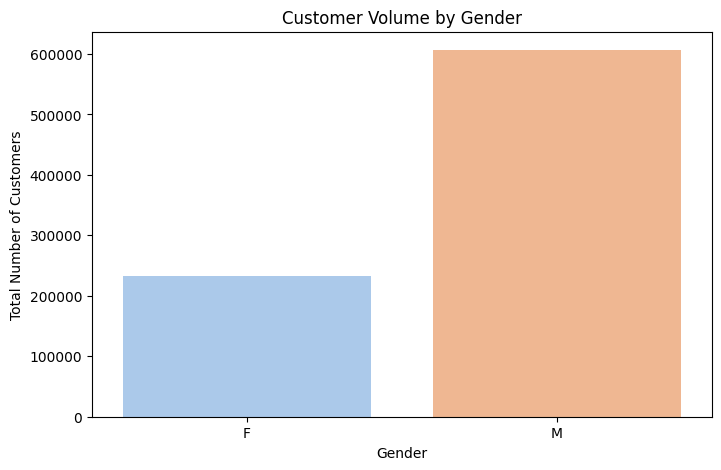

CustGender
M    72.289523
F    27.710477
Name: proportion, dtype: float64


In [26]:
plt.figure(figsize=(8, 5))
sns.countplot(data=cust_df, x='CustGender', palette='pastel')
plt.title('Customer Volume by Gender')
plt.xlabel('Gender')
plt.ylabel('Total Number of Customers')
plt.show()

# Print the exact percentages
print(cust_df['CustGender'].value_counts(normalize=True) * 100)


/tmp/ipython-input-1471276282.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cust_df, x='TotalSpend', y='CustGender', ax=ax[0], palette='Set2')
/tmp/ipython-input-1471276282.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cust_df, x='CustAccountBalance', y='CustGender', ax=ax[1], palette='Set2')


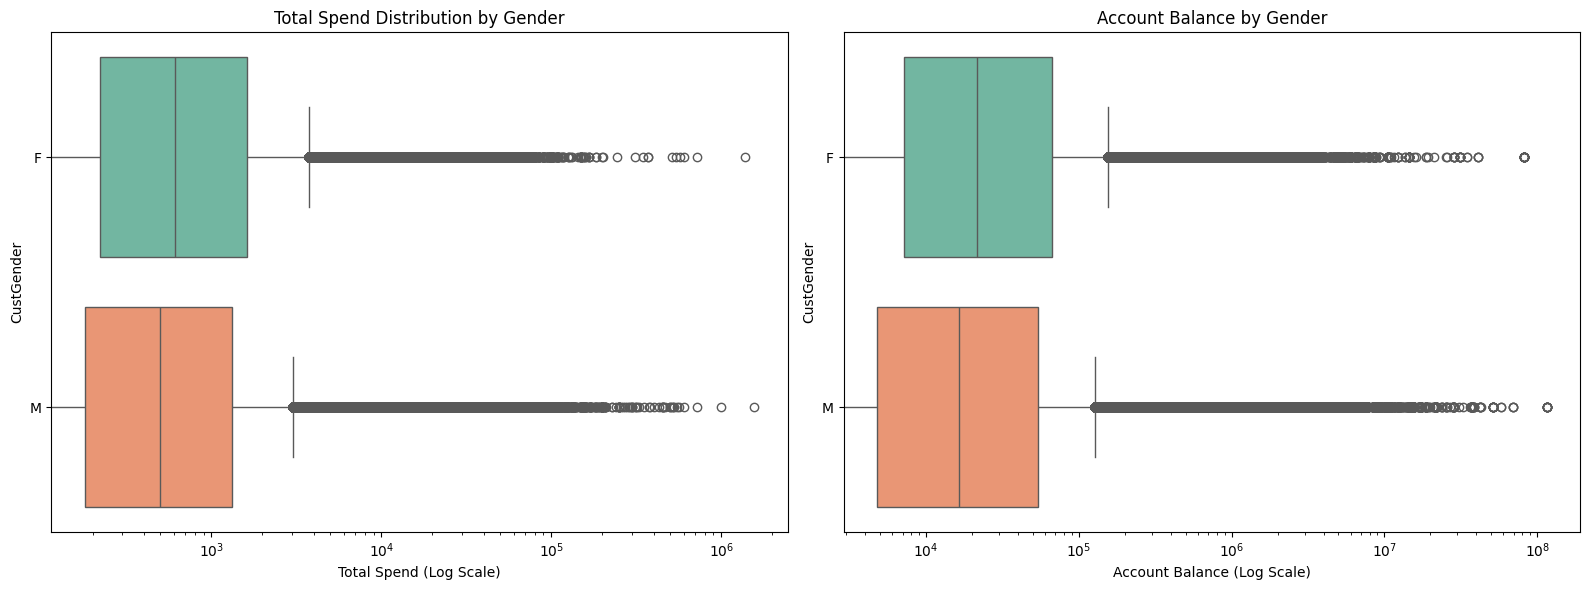

In [27]:
# Create a subplot for Spend and Balance
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Total Spend by Gender (Horizontal)
sns.boxplot(data=cust_df, x='TotalSpend', y='CustGender', ax=ax[0], palette='Set2')
ax[0].set_title('Total Spend Distribution by Gender')
ax[0].set_xscale('log') # Log scale is vital for financial outliers
ax[0].set_xlabel('Total Spend (Log Scale)')

# Account Balance by Gender (Horizontal)
sns.boxplot(data=cust_df, x='CustAccountBalance', y='CustGender', ax=ax[1], palette='Set2')
ax[1].set_title('Account Balance by Gender')
ax[1].set_xscale('log')
ax[1].set_xlabel('Account Balance (Log Scale)')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


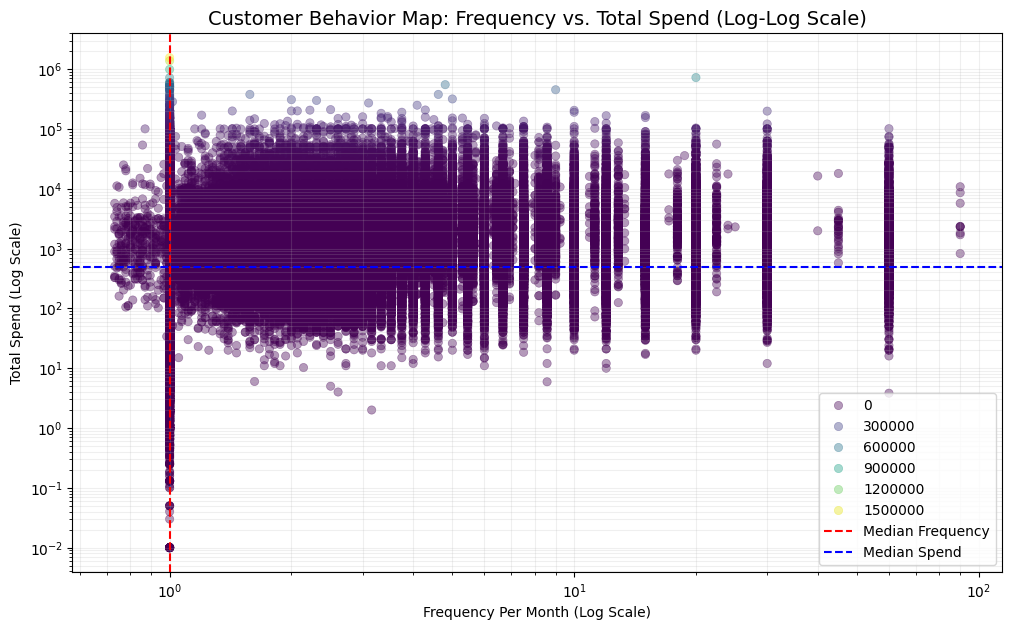

In [45]:

plt.figure(figsize=(12, 7))

# We apply log scale to both axes because both Frequency and Spend are highly skewed
sns.scatterplot(
    data=cust_df,
    x='FrequencyPerMonth',
    y='TotalSpend',
    alpha=0.4,
    edgecolor=None,
    hue='TotalSpend', # Colors points by spend to highlight the "Whales"
    palette='viridis'
)

# Apply Log Scales to both axes for better "spread"
plt.xscale('log')
plt.yscale('log')

# Add reference lines for the "Average" customer
plt.axvline(cust_df['FrequencyPerMonth'].median(), color='red', linestyle='--', label='Median Frequency')
plt.axhline(cust_df['TotalSpend'].median(), color='blue', linestyle='--', label='Median Spend')

plt.title("Customer Behavior Map: Frequency vs. Total Spend (Log-Log Scale)", fontsize=14)
plt.xlabel("Frequency Per Month (Log Scale)")
plt.ylabel("Total Spend (Log Scale)")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()


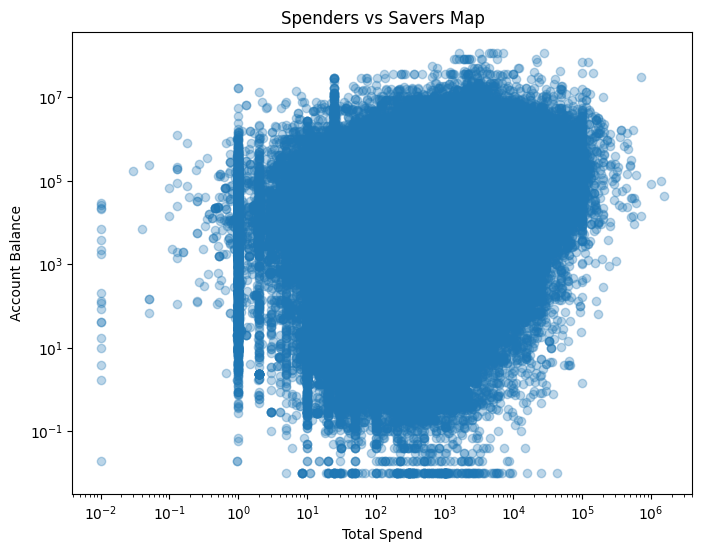

In [30]:
plt.figure(figsize=(8,6))
plt.scatter(cust_df['TotalSpend'], cust_df['CustAccountBalance'], alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Total Spend")
plt.ylabel("Account Balance")
plt.title("Spenders vs Savers Map")
plt.show()


In [31]:
cust_df.head(5)

,CustomerID,CustAccountBalance,TotalSpend,AvgSpend,MaxSpend,MinSpend,StdSpend,TransactionCount,ZeroTxnCount,LastTxnDate,FirstTxnDate,ZeroTxnFraction,RecencyDays,FrequencyPerMonth,Age,CustGender,CustLocation,NightTxnCount,NightTxnFraction,BalanceToSpendRatio,IsMetro
0,C1010011,76340.635,5106.0,2553.0,4750.0,356.0,3107.027197,2,0,2016-09-26,2016-08-09,0.0,25,1.224490,33,F,NOIDA,1.0,0.5,29.890617,0
1,C1010012,24204.490,1499.0,1499.0,1499.0,1499.0,0.000000,1,0,2016-08-14,2016-08-14,0.0,68,1.000000,31,M,MUMBAI,0.0,0.0,16.136327,1
2,C1010014,100112.950,1455.0,727.5,1205.0,250.0,675.286976,2,0,2016-08-07,2016-08-01,0.0,75,8.571429,33,F,MUMBAI,0.0,0.0,137.423404,1
3,C1010018,496.180,30.0,30.0,30.0,30.0,0.000000,1,0,2016-09-15,2016-09-15,0.0,36,1.000000,35,F,CHAMPARAN,0.0,0.0,16.005806,0
4,C1010024,87058.650,5000.0,5000.0,5000.0,5000.0,0.000000,1,0,2016-08-18,2016-08-18,0.0,64,1.000000,60,M,KOLKATA,0.0,0.0,17.408248,1


To ensure our segments are both mathematically distinct and easy to interpret, we select a subset of features that represent unique dimensions of customer behavior—such as spending power, transaction frequency, and financial stability—while removing redundant columns that would otherwise over-influence the model.

In [32]:
# List of features that define distinct behaviors
selected_features = [
    'Age',
    'TotalSpend',
    'FrequencyPerMonth',
    'RecencyDays',
    'NightTxnFraction',
    'BalanceToSpendRatio'
]

# Create the subset for clustering
cluster_data = cust_df[selected_features].copy()

# check to ensure no missing values exist in these specific columns
print("Missing values in selected features:")
print(cluster_data.isnull().sum())


Missing values in selected features:
Age                    0
TotalSpend             0
FrequencyPerMonth      0
RecencyDays            0
NightTxnFraction       0
BalanceToSpendRatio    0
dtype: int64


We visualize the effect of log transformation on the `TotalSpend` feature, comparing its original right-skewed distribution with the normalized log-transformed distribution.


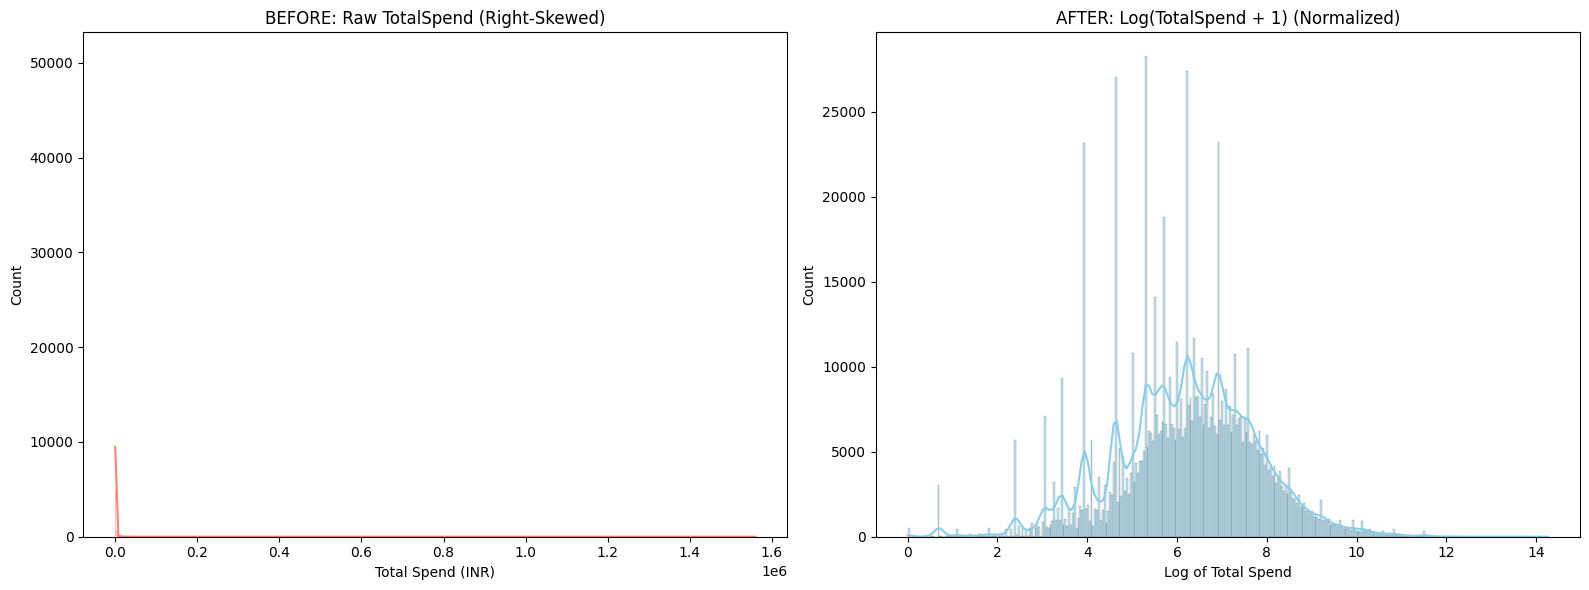

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Before: Raw TotalSpend (Highly Skewed)
sns.histplot(cust_df['TotalSpend'], kde=True, ax=ax1, color='salmon')
ax1.set_title('BEFORE: Raw TotalSpend (Right-Skewed)')
ax1.set_xlabel('Total Spend (INR)')

# 2. After: Log-Transformed TotalSpend
# np.log1p handles 0 values by adding 1 before taking the log
sns.histplot(np.log1p(cust_df['TotalSpend']), kde=True, ax=ax2, color='skyblue')
ax2.set_title('AFTER: Log(TotalSpend + 1) (Normalized)')
ax2.set_xlabel('Log of Total Spend')

plt.tight_layout()
plt.show()


In [34]:
# Calculate skewness for original and transformed data
original_skew = cust_df['TotalSpend'].skew()
transformed_skew = np.log1p(cust_df['TotalSpend']).skew()

print(f"Skewness Score BEFORE: {original_skew:.2f}")
print(f"Skewness Score AFTER:  {transformed_skew:.2f}")


Skewness Score BEFORE: 52.17
Skewness Score AFTER:  -0.20


In [35]:
# Skewness Check
skew_report = cust_df[selected_features].skew().sort_values(ascending=False)
print("--- Skewness Scores (Higher = More Skewed) ---")
print(skew_report)


--- Skewness Scores (Higher = More Skewed) ---
BalanceToSpendRatio    329.340305
TotalSpend              52.168249
FrequencyPerMonth        8.883036
NightTxnFraction         4.726520
Age                      1.778561
RecencyDays             -0.230516
dtype: float64


We apply log transformation to reduce skewness in selected numeric features and check the updated skewness scores.


In [36]:

# Create a copy for the transformed data
cust_df_transformed = cust_df[selected_features].copy()

# Features that clearly need the 'volume turned down'
to_log = ['BalanceToSpendRatio', 'TotalSpend', 'FrequencyPerMonth', 'NightTxnFraction']

for col in to_log:
    cust_df_transformed[col] = np.log1p(cust_df_transformed[col])

# Verify the new skewness
print("--- New Skewness Scores ---")
print(cust_df_transformed.skew().sort_values(ascending=False))


--- New Skewness Scores ---
NightTxnFraction       4.622454
FrequencyPerMonth      3.650788
Age                    1.778561
BalanceToSpendRatio    0.244764
TotalSpend            -0.204502
RecencyDays           -0.230516
dtype: float64


In [37]:
cust_df_transformed.head(5)

,Age,TotalSpend,FrequencyPerMonth,RecencyDays,NightTxnFraction,BalanceToSpendRatio
0,33,8.538367,0.799528,25,0.405465,3.430452
1,31,7.313220,0.693147,68,0.000000,2.841201
2,33,7.283448,2.258782,75,0.000000,4.930317
3,35,3.433987,0.693147,36,0.000000,2.833555
4,60,8.517393,0.693147,64,0.000000,2.912799


We standardize all selected features to the same scale so no single variable dominates distance-based clustering.

In [38]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Initialize the scaler
scaler = StandardScaler()

# Apply to our log-transformed data
scaled_values = scaler.fit_transform(cust_df_transformed)

# Convert back to a DataFrame
cust_scaled_df = pd.DataFrame(
    scaled_values,
    columns=selected_features,
    index=cust_df_transformed.index
)

#Verifying the scaling (Mean should be ~0, Std should be ~1)
print("--- Scaling Verification ---")
print(cust_scaled_df.agg(['mean', 'std']).round(2))

cust_scaled_df.head()


--- Scaling Verification ---
      Age  TotalSpend  FrequencyPerMonth  RecencyDays  NightTxnFraction  \
mean -0.0        -0.0                0.0         -0.0               0.0   
std   1.0         1.0                1.0          1.0               1.0   

      BalanceToSpendRatio  
mean                 -0.0  
std                   1.0  


,Age,TotalSpend,FrequencyPerMonth,RecencyDays,NightTxnFraction,BalanceToSpendRatio
0,-0.817385,1.472813,-0.115447,-1.997892,2.872596,-0.132837
1,-1.046099,0.703837,-0.340111,0.827351,-0.213971,-0.427345
2,-0.817385,0.685150,2.966345,1.287275,-0.213971,0.616795
3,-0.588671,-1.731006,-0.340111,-1.275155,-0.213971,-0.431167
4,2.270258,1.459648,-0.340111,0.564538,-0.213971,-0.391561


This evaluates different cluster counts to identify a suitable number of customer segments based on diminishing returns in within-cluster variation.

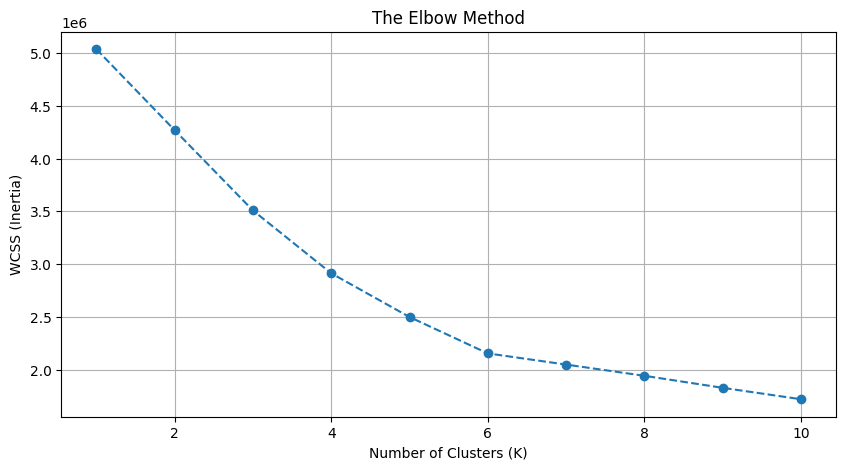

In [39]:
from sklearn.cluster import KMeans


wcss = []
# We test K values from 1 to 10
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(cust_scaled_df)
    wcss.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)
plt.show()


Apply K-Means with the selected number of clusters and summarizes each segment using average behavioral, financial, and engagement metrics to define customer personas.

In [40]:
# Run final K-Means with K=4
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
cust_df['Cluster'] = kmeans.fit_predict(cust_scaled_df)

# Calculate the mean of each feature per cluster to define personas
cluster_profiles = cust_df.groupby('Cluster').agg({
    'Age': 'mean',
    'TotalSpend': 'mean',
    'FrequencyPerMonth': 'mean',
    'RecencyDays': 'mean',
    'BalanceToSpendRatio': 'mean',
    'NightTxnFraction': 'mean',
    'IsMetro': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'ClusterSize'}).reset_index()

# Display the profiles
print("--- Cluster Profiling Table ---")
display(cluster_profiles.sort_values(by='TotalSpend', ascending=False))


--- Cluster Profiling Table ---


,Cluster,Age,TotalSpend,FrequencyPerMonth,RecencyDays,BalanceToSpendRatio,NightTxnFraction,IsMetro,ClusterSize
3,3,40.134056,3139.773611,11.249198,53.179291,205.837835,0.028440,0.347052,67912
0,0,42.014714,2706.232311,1.121588,55.387031,34.005785,0.000447,0.351933,401128
2,2,38.403117,1280.115446,1.328309,56.146950,2287.026624,0.919722,0.354728,33685
1,1,38.097643,263.606548,1.065331,55.808589,1355.195668,0.000169,0.324383,336214


Examine the distribution of customers across segments to understand their relative size and importance.

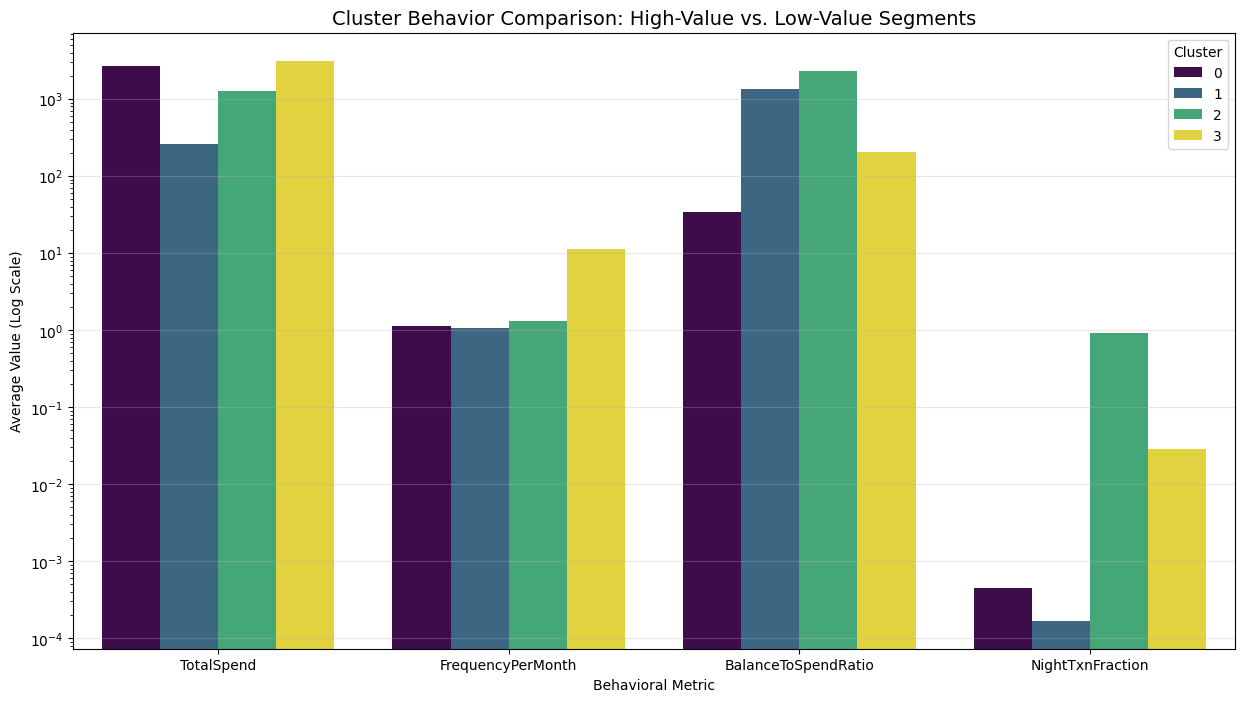

In [41]:
# focus on the most defining behavioral metrics
plot_features = ['TotalSpend', 'FrequencyPerMonth', 'BalanceToSpendRatio', 'NightTxnFraction']
cluster_avg = cluster_profiles.melt(id_vars='Cluster', value_vars=plot_features)

plt.figure(figsize=(15, 8))
sns.barplot(data=cluster_avg, x='variable', y='value', hue='Cluster', palette='viridis')
plt.title("Cluster Behavior Comparison: High-Value vs. Low-Value Segments", fontsize=14)
plt.yscale('log')  # Log scale helps see small values (Frequency) and large ones (Spend) together
plt.ylabel("Average Value (Log Scale)")
plt.xlabel("Behavioral Metric")
plt.legend(title='Cluster')
plt.grid(axis='y', alpha=0.3)
plt.show()


Assign descriptive business-friendly labels to clusters based on their behavioral and financial characteristics.

In [42]:
# Define the personas based on our centroid analysis
cluster_names = {
    3: "VIP Power Users",        # High Spend, High Frequency
    0: "Standard Spenders",     # Solid Spend, Monthly Frequency
    2: "Night-Owl Savers",      # Extreme Night Activity, High Balance
    1: "Dormant/Occasional"     # Low Spend, Low Engagement
}

# Apply the names to the dataframe
cust_df['SegmentName'] = cust_df['Cluster'].map(cluster_names)

# Verify the mapping and see the distribution
print(cust_df[['CustomerID', 'Cluster', 'SegmentName']].head())
print("\n--- Market Share by Segment ---")
print(cust_df['SegmentName'].value_counts(normalize=True) * 100)


  CustomerID  Cluster         SegmentName
0   C1010011        2    Night-Owl Savers
1   C1010012        0   Standard Spenders
2   C1010014        3     VIP Power Users
3   C1010018        1  Dormant/Occasional
4   C1010024        0   Standard Spenders

--- Market Share by Segment ---
SegmentName
Standard Spenders     47.813727
Dormant/Occasional    40.076096
VIP Power Users        8.094987
Night-Owl Savers       4.015191
Name: proportion, dtype: float64


location wise analysis

/tmp/ipython-input-1195441068.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locations.values, y=top_locations.index, palette='magma')


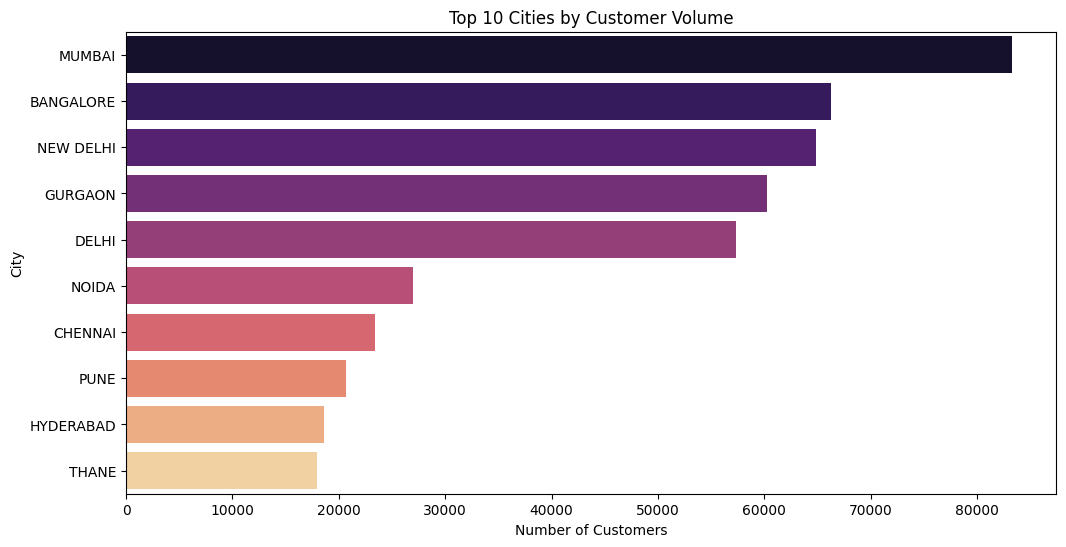

In [43]:
# Check top 10 locations by customer count
top_locations = cust_df['CustLocation'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_locations.values, y=top_locations.index, palette='magma')
plt.title('Top 10 Cities by Customer Volume')
plt.xlabel('Number of Customers')
plt.ylabel('City')
plt.show()


Compare how customer segments are distributed across metropolitan and non-metropolitan locations to uncover geographic behavior differences.

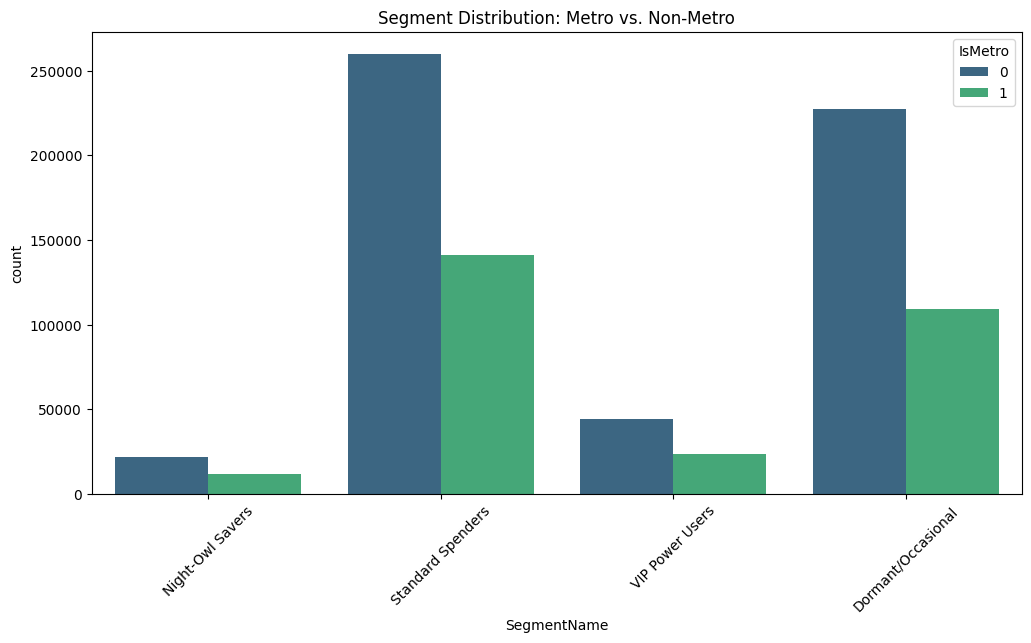

In [44]:
# Compare Segment distribution across Metro vs Non-Metro
plt.figure(figsize=(12, 6))
sns.countplot(data=cust_df, x='SegmentName', hue='IsMetro', palette='viridis')
plt.title('Segment Distribution: Metro vs. Non-Metro')
plt.xticks(rotation=45)
plt.show()


    Conclusion

This project demonstrates the segmentation of bank customers using unsupervised learning, transforming raw features to reduce skewness and reveal meaningful patterns. By applying clustering techniques, we identified distinct customer groups, enabling targeted strategies and personalized engagement.

We found that the largest group consists of Standard Spenders (48%), followed by Dormant/Occasional users (40%), while VIP Power Users (8%) and Night-Owl Savers (4%) represent smaller, high-value segments.

    Key Takeaways:

Cluster Insights: Customers naturally grouped into segments such as Night Owls, Big Spenders, reflecting distinct spending habits and transaction behaviors.

Feature Importance: Features like total spend, frequency, and night-time transactions drove cluster formation, highlighting actionable patterns for marketing and customer relationship management.